In [1]:
import hmclab
import numpy, matplotlib.pyplot as plt

# Tutorial 1 - Tuning Hamiltonian Monte Carlo

In this tutorial the tuning parameters of Hamiltonian Monte Carlo are exhaustively discussed. Additionally, best practices are given that will help with the practical usage of HMC. 

## Too long, I want a shortlist

A shortlist of these best practices is:

- Enable autotuning for stepsize **(default: off)**
- Use 0.5-0.9 for your target acceptance rate in autotuning **(default: 0.65)**
- Use 10 integration steps **(default: 10)**
- Use an optimal diagonal mass matrix which injects the expected variability of parameters **(default: unit)**
- Randomize stepsize for each trajectory **(default: on)**

Thus, optimal settings for many problems can be implemented by:
```
results = sampler.sample(
    "samples.h5",
    posterior
    autotuning=True,
)
```


## Tuning parameters

Hamiltonian Monte Carlo has various tuning settings. The most important settings are:

1. **Integration step length** `stepsize`

> The time discretization in Hamilton's equations, or the equations of motion. This controls how much (artificial) time is passed before recomputing a gradient in the leapfrog integration scheme.

2. **Amount of integration steps** `amount_of_steps`

> The number of discrete time steps in Hamilton's equations. Increasing this number is the main control on how expensive a proposal is, as more steps require more gradients.

3. **Autotuning** `auotuning`

> This on/off switch enables the automatic estimation of optimal value for parameter 1. It has additional associated settings that are shown in this notebook.

4. **Stepsize randomization** `randomize_stepsize`

> This on/off switch allows us to slighty randomize tuning parameter 1. This is useful for reasons shown later.

5. **Mass matrix** `mass_matrix`

> The mass matrix is a collection of artificial masses associated with Hamilton's equations. It allows us to precondition the model space.


We will start showcasing the HMC algorithm on a simple 2 dimensional standard normal Gaussian, i.e. a Gaussian with mean zero and variance 1.

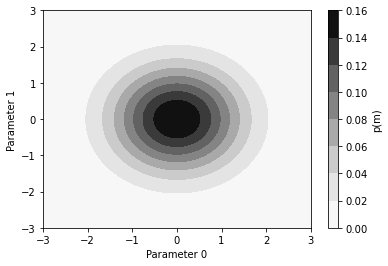

In [2]:
StandardNormal_2d = hmclab.Distributions.Normal([0, 0], [1, 1])

domain = [-3, 3, -3, 3]

x1s = numpy.linspace(domain[0], domain[1], 100)
x2s = numpy.linspace(domain[2], domain[3], 100)

grid = numpy.stack(numpy.meshgrid(x1s, x2s))

background_image = numpy.empty_like(grid[0, :, :])

for ix1 in range(100):
    for ix2 in range(100):
        background_image[ix1, ix2] = StandardNormal_2d.misfit(grid[:, ix1, ix2, None])


background = (x1s, x2s, background_image)


plt.contourf(
    x1s,
    x2s,
    numpy.exp(-background_image)
    / numpy.sum(numpy.exp(-background_image) * (x1s[1] - x1s[0]) * (x2s[1] - x2s[0])),
    cmap=plt.get_cmap("Greys"),
)
plt.xlabel("Parameter 0")
plt.ylabel("Parameter 1")
cbar = plt.colorbar()
_ = cbar.ax.set_ylabel("p(m)")

Important notes:

1. We give a random seed to the sampler. Therefore results will be the same for each run with the same tuning parameters, making the run reproducible. If one would not give a seed, it is randomly generated.
2. Statistics like acceptance rate and time/sample or sample/time are given below the plots.
3. The contours shown on all right hand figures are typically not known before sampling, this is in fact the function we explore with MCMC. They are included for illustrative purposes.
4. This notebook uses all the original code for HMC, extended with animations of the proposals. The usage of this `hmclab.Samplers.HMC_visual` sampler is virtually identical to that of `hmclab.Samplers.HMC`, although the instantiation is different.

## Time discretization

The two parameters `stepsize` & `amount_of_steps` combined control how much artificial time passes per trajectory. Let's have a look at three proposals made with a total integration time of 1 artifical second (`0.1 * 10`):

<Figure size 720x360 with 0 Axes>

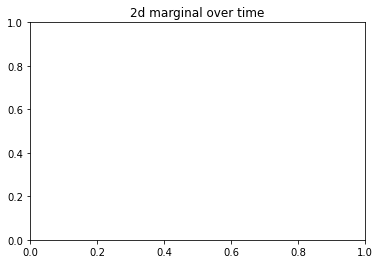

In [3]:
# Create the sampler
sampler = hmclab.Samplers.HMC_visual(
    animate_proposals=True,
    animation_domain=domain,
    leave_proposal_animation=True,
    seed=78,
    background=background,
)

proposals = 3

### Tuning parameters -------------

stepsize = 0.1
amount_of_steps = 10

### -------------------------------

results = sampler.sample(
    "bin_samples/tutorial_1_samples.h5",
    StandardNormal_2d,
    # Tuning parameters
    stepsize=stepsize,
    amount_of_steps=amount_of_steps,
    proposals=proposals,
    # Where we start our MCMC
    initial_model=[2, 1],
    # Don't worry about these for now
    randomize_stepsize=False,
    autotuning=False,
    overwrite_existing_file=True,
)

Not all three trajectories are the same length. This is because a different initial momentum was drawn for each proposal. What is equal for these three trajectories, is total time passed.

Let's see what happens if we keep the total integration time the same, but use more steps in the integration of Hamilton's equations. We will now do 20 steps at half the stepsize:

<Figure size 720x360 with 0 Axes>

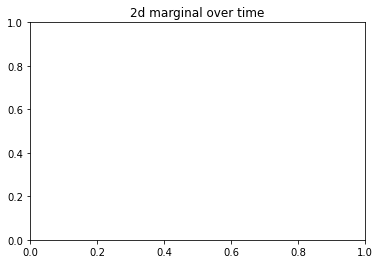

In [4]:
sampler = hmclab.Samplers.HMC_visual(
    animate_proposals=True,
    animation_domain=domain,
    leave_proposal_animation=True,
    seed=78,
    background=background,
)

proposals = 3

### Tuning parameters -------------

stepsize = 0.05
amount_of_steps = 20

### -------------------------------

results = sampler.sample(
    "bin_samples/tutorial_1_samples.h5",
    StandardNormal_2d,
    stepsize=stepsize,
    amount_of_steps=amount_of_steps,
    proposals=proposals,
    initial_model=[2, 1],
    randomize_stepsize=False,
    autotuning=False,
    overwrite_existing_file=True,
)

Interestingly, this produces exactly the same trajectories. This is because the same time passes for the trajectories in either Markoc chain. Because we discretise Hamilton's equations, the results are not the same up to machine precision. This second Markov chain will probably have integrated these equations better. Better in this context means with more exact conservation of energy

What one also might notice is that this second Markov chain took longer to compute. The performance difference between the 10 steps and 20 steps is approximately a factor of 2. This is because the second chain uses more gradient computations.

Going in the other direction works as well. By reducing the amount of steps but increasing the stepsize, we hopefully get the same trajectories:

<Figure size 720x360 with 0 Axes>

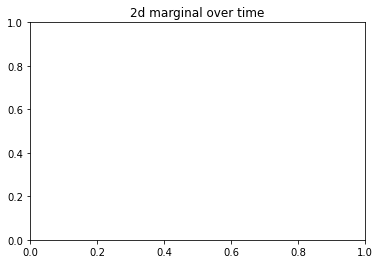

In [5]:
sampler = hmclab.Samplers.HMC_visual(
    animate_proposals=True,
    animation_domain=domain,
    leave_proposal_animation=True,
    seed=78,
    background=background,
)

proposals = 3

### Tuning parameters -------------

stepsize = 0.2
amount_of_steps = 5

### -------------------------------

results = sampler.sample(
    "bin_samples/tutorial_1_samples.h5",
    StandardNormal_2d,
    stepsize=stepsize,
    amount_of_steps=amount_of_steps,
    proposals=proposals,
    initial_model=[2, 1],
    randomize_stepsize=False,
    autotuning=False,
    overwrite_existing_file=True,
)

In this last case, the algorithm was even faster to propose new models.

The questions now of course arises; can we not raise our stepsize to some incredibly high number, to make proposals that are very distant (which is typically a good thing in MCMC apparaisals)?

The answer, is sadly no. The following cell will show that increasing the stepsize by too much will lower the acceptance rate of Hamiltonian Monte Carlo.

<Figure size 720x360 with 0 Axes>

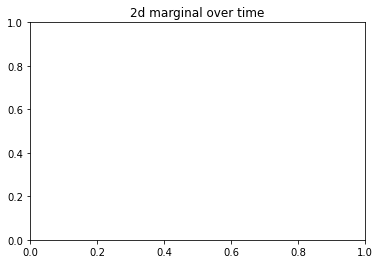

In [6]:
sampler = hmclab.Samplers.HMC_visual(
    animate_proposals=True,
    animation_domain=domain,
    leave_proposal_animation=True,
    seed=78,
    background=background,
)

proposals = 3

### Tuning parameters -------------

stepsize = 1.55
amount_of_steps = 2

### -------------------------------

results = sampler.sample(
    "bin_samples/tutorial_1_samples.h5",
    StandardNormal_2d,
    stepsize=stepsize,
    amount_of_steps=amount_of_steps,
    proposals=proposals,
    initial_model=[2, 1],
    randomize_stepsize=False,
    autotuning=False,
    overwrite_existing_file=True,
)

This poor acceptance rate is because the equations of motion are not accurately integrated. This breaks the conservation of energy and thus the algorithm performs poorly.

### Conclusions 

We can condense what we learned about `stepsize` and `amount_of_steps` for HMC in the following rules:

1. A longer total integration time (`stepsize * amount_of_steps`) will lead to more distant samplers. More distant samples leads to better MCMC mixing and thereby faster convergence. Increasing either parameter will therefore yield better convergence.
2. ... **UNLESS** `stepsize` is increased so much that acceptance rate suffers. If no new models are accepted (because e.g. the `stepsize` is too big), the MCMC algorithm will perform poorly. and, ...
3. ... **UNLESS** `amount_of_steps` is excessively high. Doing many steps in a trajectory will require many gradient evaluations, which might make the HMC algorithm run very slow.

The optimal acceptance rate is found for Gaussians to be 0.65. We recommend, based on experience, to change the `stepsize` (by trial and error) such that the acceptance rate of the Markov chain lies between 0.5 - 0.9. This notebook will further on show how this can be done automatically.

The optimal amount of integration steps is unknown. We recommend, based on experience, to use between 3 - 15 integration steps.

### Autotuning

The tedious process of tuning the stepsize can be automated. For example, sometimes the chosen stepsize is wildly inappropriate for the target function:

<Figure size 720x360 with 0 Axes>

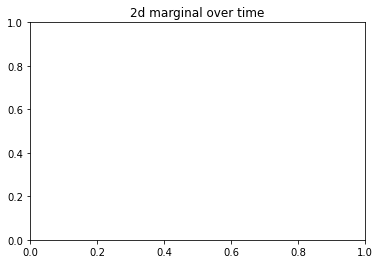

In [7]:
# Create the sampler
sampler = hmclab.Samplers.HMC_visual(
    animate_proposals=True,
    animation_domain=domain,
    leave_proposal_animation=True,
    seed=78,
    background=background,
)

proposals = 20

### Tuning parameters -------------

stepsize = 1e-2
amount_of_steps = 10

### -------------------------------

results = sampler.sample(
    "bin_samples/tutorial_1_samples.h5",
    StandardNormal_2d,
    # Tuning parameters
    stepsize=stepsize,
    amount_of_steps=amount_of_steps,
    proposals=proposals,
    # Where we start our MCMC
    initial_model=[2, 1],
    # Don't worry about these for now
    randomize_stepsize=False,
    autotuning=False,
    overwrite_existing_file=True,
)

By simply adding `autotuning=True` and a desired `target_acceptance_rate`, the algorithm tries to automatically optimize the `stepsize` of the algorithm:

<Figure size 720x360 with 0 Axes>

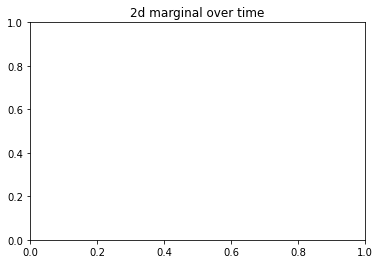

In [8]:
# Create the sampler
sampler = hmclab.Samplers.HMC_visual(
    animate_proposals=True,
    animation_domain=domain,
    leave_proposal_animation=True,
    seed=78,
    background=background,
)

proposals = 20

### Tuning parameters -------------

stepsize = 1e-2
amount_of_steps = 10

autotuning = True
target_acceptance_rate = 0.9

### -------------------------------

results = sampler.sample(
    "bin_samples/tutorial_1_samples.h5",
    StandardNormal_2d,
    # Tuning parameters
    stepsize=stepsize,
    amount_of_steps=amount_of_steps,
    proposals=proposals,
    # Where we start our MCMC
    initial_model=[2, 1],
    # Don't worry about these for now
    randomize_stepsize=True,
    autotuning=autotuning,
    target_acceptance_rate=target_acceptance_rate,
    overwrite_existing_file=True,
)

## B: Resonance and `stepsize` randomization

It is found in specific cases that MCMC algorithms resonate between states. The easiest example of this is when one applies HMC to any Gaussian (e.g. our test function) and integrates the trajectories for a total integration time that is a multiple of $\pi$:

<Figure size 720x360 with 0 Axes>

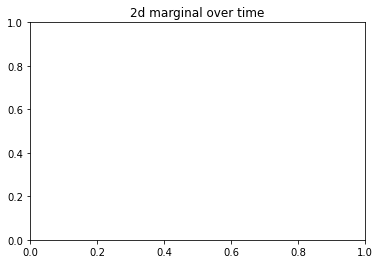

In [9]:
# Create the sampler
sampler = hmclab.Samplers.HMC_visual(
    animate_proposals=True,
    animation_domain=domain,
    leave_proposal_animation=True,
    seed=78,
    background=background,
)

proposals = 100

### Tuning parameters -------------

stepsize = numpy.pi / 10
amount_of_steps = 10


### -------------------------------

results = sampler.sample(
    "bin_samples/tutorial_1_samples.h5",
    StandardNormal_2d,
    # Tuning parameters
    stepsize=stepsize,
    amount_of_steps=amount_of_steps,
    proposals=proposals,
    # Where we start our MCMC
    initial_model=[2, 1],
    # Don't worry about these for now
    randomize_stepsize=False,
    autotuning=False,
    overwrite_existing_file=True,
)

These states might be extremely difficult to detect, especially for higher dimensional Markov chains. Therefore, we recommend to randomize the stepsize per trajectory slightly, as done in the following cell which leaves all other tuning parameters equal. This randomization is enabled by default.

<Figure size 720x360 with 0 Axes>

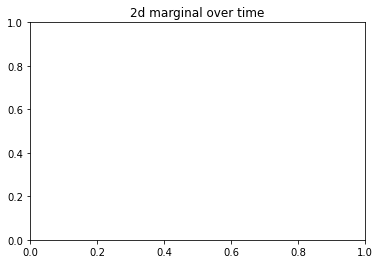

In [10]:
# Create the sampler
sampler = hmclab.Samplers.HMC_visual(
    animate_proposals=True,
    animation_domain=domain,
    leave_proposal_animation=True,
    seed=78,
    background=background,
)

proposals = 10

### Tuning parameters -------------

stepsize = numpy.pi / 10
amount_of_steps = 10

randomize_stepsize = True

### -------------------------------

results = sampler.sample(
    "bin_samples/tutorial_1_samples.h5",
    StandardNormal_2d,
    stepsize=stepsize,
    amount_of_steps=amount_of_steps,
    proposals=proposals,
    initial_model=[2, 1],
    randomize_stepsize=randomize_stepsize,
    autotuning=False,
    overwrite_existing_file=True,
)

# Mass matrix

Sometimes the distribution that is investigated is heavily distorted in model space, having a much larger variability in one dimension than the other. We give an example below of a Gaussian that has a major axis that is 3 times longer than the minor axis:

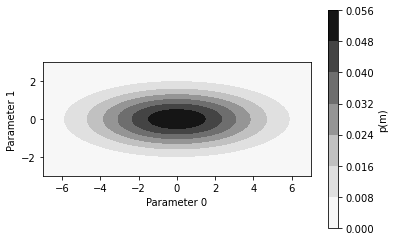

In [11]:
ElongatedNormal_2d = hmclab.Distributions.Normal([0, 0], [3**2, 1**2])

domain = [-7, 7, -3, 3]

x1s = numpy.linspace(domain[0], domain[1], 100)
x2s = numpy.linspace(domain[2], domain[3], 100)

grid = numpy.stack(numpy.meshgrid(x1s, x2s))

background_image = numpy.empty_like(grid[0, :, :])

for ix1 in range(100):
    for ix2 in range(100):
        background_image[ix1, ix2] = ElongatedNormal_2d.misfit(grid[:, ix1, ix2, None])


background = (x1s, x2s, background_image)


plt.contourf(
    x1s,
    x2s,
    numpy.exp(-background_image)
    / numpy.sum(numpy.exp(-background_image) * (x1s[1] - x1s[0]) * (x2s[1] - x2s[0])),
    cmap=plt.get_cmap("Greys"),
)
plt.gca().set_aspect(1)
plt.xlabel("Parameter 0")
plt.ylabel("Parameter 1")
cbar = plt.colorbar()
_ = cbar.ax.set_ylabel("p(m)")

Although the HMC algorithm would sample this distribution rather easily, performance is affected by the elongation. This is becauseto traverse to long axis, more oscillations in the short axis are needed. This is shown below.

<Figure size 720x360 with 0 Axes>

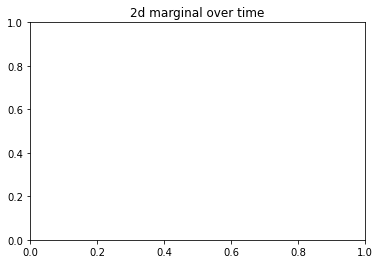

In [12]:
sampler = hmclab.Samplers.HMC_visual(
    animate_proposals=True,
    animation_domain=domain,
    leave_proposal_animation=True,
    seed=78,
    background=background,
)

### Tuning parameters -------------

stepsize = 0.2
amount_of_steps = 60

proposals = 3

randomize_stepsize = True


### -------------------------------

results = sampler.sample(
    "bin_samples/tutorial_1_samples.h5",
    ElongatedNormal_2d,
    stepsize=stepsize,
    randomize_stepsize=randomize_stepsize,
    amount_of_steps=amount_of_steps,
    proposals=proposals,
    initial_model=[2, 0],
    overwrite_existing_file=True,
)

These trajectories (that are very similar to Lissajous figures) are orbits that don't oscillate with equal frequency in the space. Upon inspection you might see that they on average oscillates about 3 times more often in the vertical direction. 

This behaviour can be compensated for by HMC, which in turn will make the algorithm more efficient. It is done by assigning a different mass per dimension in an artificial mass matrix. By precisely using the inverse square of the standard deviation (i.e. the inverse convariance) of the posterior, these unequal oscillations are removed. Practically, using this mass matrix preconditions model space for HMC algorithm.

**NOTE that typically the distribution is not as well known as in these examples.** However, performing appraisals on parameters with wildly different magnitude ranges, this may still prove a very important preconditioning step.

<Figure size 720x360 with 0 Axes>

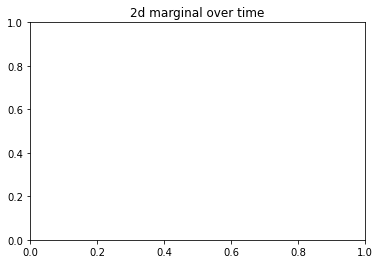

In [13]:
sampler = hmclab.Samplers.HMC_visual(
    animate_proposals=True,
    animation_domain=domain,
    leave_proposal_animation=True,
    seed=78,
    background=background,
)

### Tuning parameters -------------

stepsize = 0.1
amount_of_steps = 20

proposals = 20

randomize_stepsize = True

mass_matrix = hmclab.MassMatrices.Diagonal([(1 / 3) ** 2, 1])

### -------------------------------

results = sampler.sample(
    "bin_samples/tutorial_1_samples.h5",
    ElongatedNormal_2d,
    stepsize=stepsize,
    randomize_stepsize=randomize_stepsize,
    amount_of_steps=amount_of_steps,
    proposals=proposals,
    initial_model=[2, 0],
    mass_matrix=mass_matrix,
    overwrite_existing_file=True,
)

Applying the opposite of this mass matrix (as if the Gaussian had the inverse aspect ratio) actively worsens the results:

<Figure size 720x360 with 0 Axes>

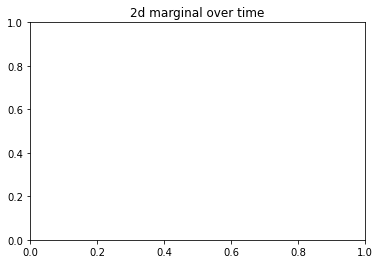

In [14]:
sampler = hmclab.Samplers.HMC_visual(
    animate_proposals=False,
    animation_domain=domain,
    leave_proposal_animation=True,
    seed=78,
    background=background,
)

### Tuning parameters -------------

stepsize = 0.1
amount_of_steps = 20

proposals = 20

randomize_stepsize = True

mass_matrix = hmclab.MassMatrices.Diagonal([3**2, 1])

### -------------------------------

results = sampler.sample(
    "bin_samples/tutorial_1_samples.h5",
    ElongatedNormal_2d,
    stepsize=stepsize,
    randomize_stepsize=randomize_stepsize,
    amount_of_steps=amount_of_steps,
    proposals=proposals,
    initial_model=[2, 0],
    mass_matrix=mass_matrix,
    overwrite_existing_file=True,
)

**However**, the algorithm in this case still (slowly) converges, even with an inadequate mass matrix.

<Figure size 720x360 with 0 Axes>

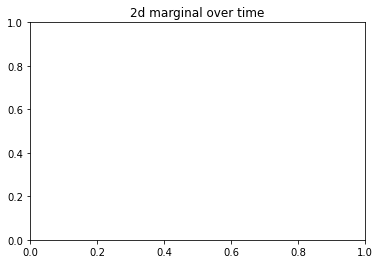

In [15]:
sampler = hmclab.Samplers.HMC_visual(
    animate_proposals=False,
    animation_domain=domain,
    leave_proposal_animation=True,
    seed=78,
    background=background,
)

### Tuning parameters -------------

stepsize = 0.1
amount_of_steps = 20

proposals = 2500

randomize_stepsize = True

mass_matrix = hmclab.MassMatrices.Diagonal([3**2, 1])

### -------------------------------

results = sampler.sample(
    "bin_samples/tutorial_1_samples.h5",
    ElongatedNormal_2d,
    stepsize=stepsize,
    randomize_stepsize=randomize_stepsize,
    amount_of_steps=amount_of_steps,
    proposals=proposals,
    initial_model=[2, 0],
    mass_matrix=mass_matrix,
    overwrite_existing_file=True,
)

## Mass matrix - time integration trade-off

In the HMC algorithm the time step and mass matrix trade-off perfectly. Multiplying the time step by a factor $f$ is equivalent to dividing the matrix by the exact same factor squared, $f^2$. 

The following cell produces the exact same trajectories as the mass matrix from 3 cells back, although both the mass matrix and time step are altered.

<Figure size 720x360 with 0 Axes>

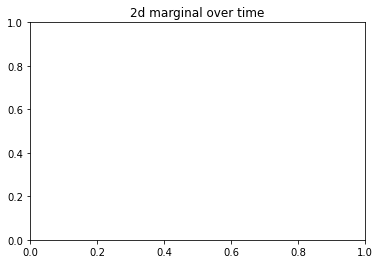

In [16]:
sampler = hmclab.Samplers.HMC_visual(
    animate_proposals=True,
    animation_domain=domain,
    leave_proposal_animation=True,
    seed=78,
    background=background,
)

### Tuning parameters -------------

stepsize = 0.2 * 1e-5
amount_of_steps = 10

proposals = 10

randomize_stepsize = True


mass_matrix = hmclab.MassMatrices.Diagonal([1e-10 * (1 / 3) ** 2, 1e-10 * 1])

### -------------------------------

results = sampler.sample(
    "bin_samples/tutorial_1_samples.h5",
    ElongatedNormal_2d,
    stepsize=stepsize,
    randomize_stepsize=randomize_stepsize,
    amount_of_steps=amount_of_steps,
    proposals=proposals,
    initial_model=[4, 1],
    mass_matrix=mass_matrix,
    overwrite_existing_file=True,
)

## Correlations

When the posterior contains correlations in parameters (e.g. when two parameters trade-off) we can do even more to accelerate the convergence of HMC, especially when these correlations are a-priori suspected.

Below we create a strongly correlated Gaussian with the same variance as our previous examples, but with a different covariance.

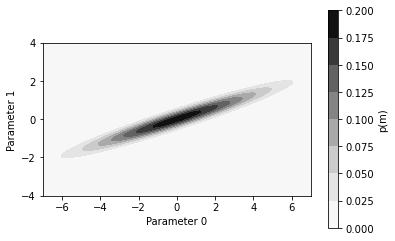

In [17]:
covariance = numpy.array([[9, 2.88], [2.88, 1]])

CorrelatedNormal_2d = hmclab.Distributions.Normal([0, 0], covariance)

domain = [-7, 7, -4, 4]

x1s = numpy.linspace(domain[0], domain[1], 100)
x2s = numpy.linspace(domain[2], domain[3], 100)

grid = numpy.stack(numpy.meshgrid(x1s, x2s))

background_image = numpy.empty_like(grid[0, :, :])

for ix1 in range(100):
    for ix2 in range(100):
        background_image[ix1, ix2] = CorrelatedNormal_2d.misfit(grid[:, ix1, ix2, None])


background = (x1s, x2s, background_image)


plt.contourf(
    x1s,
    x2s,
    numpy.exp(-background_image)
    / numpy.sum(numpy.exp(-background_image) * (x1s[1] - x1s[0]) * (x2s[1] - x2s[0])),
    cmap=plt.get_cmap("Greys"),
)
plt.gca().set_aspect(1)
plt.xlabel("Parameter 0")
plt.ylabel("Parameter 1")
cbar = plt.colorbar()
_ = cbar.ax.set_ylabel("p(m)")

When we apply the HMC algorithm using the diagonal mass matrix from the previous example, we again get Lissajous trajectories that waste some computations.

<Figure size 720x360 with 0 Axes>

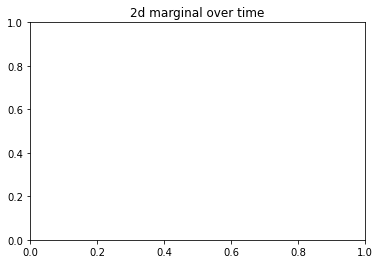

In [18]:
sampler = hmclab.Samplers.HMC_visual(
    animate_proposals=True,
    animation_domain=domain,
    leave_proposal_animation=True,
    seed=78,
    background=background,
)

### Tuning parameters -------------

stepsize = 0.2
amount_of_steps = 10

proposals = 10

randomize_stepsize = True

mass_matrix = hmclab.MassMatrices.Diagonal([(1 / 3) ** 2, 1])

### -------------------------------

results = sampler.sample(
    "bin_samples/tutorial_1_samples.h5",
    CorrelatedNormal_2d,
    stepsize=stepsize,
    randomize_stepsize=randomize_stepsize,
    amount_of_steps=amount_of_steps,
    proposals=proposals,
    initial_model=[4, 1],
    mass_matrix=mass_matrix,
    overwrite_existing_file=True,
)

 One avoids this by supplying the HMC algorithm with the (inverse) expected covariance algorithm using the mass matrix, which will again precondition the algorithnm to work appropriately on the target distribution. 

<Figure size 720x360 with 0 Axes>

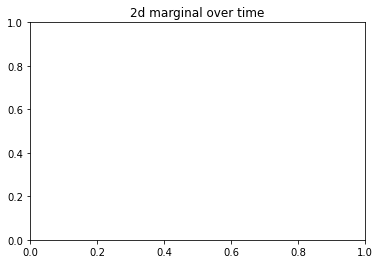

In [19]:
sampler = hmclab.Samplers.HMC_visual(
    animate_proposals=True,
    animation_domain=domain,
    leave_proposal_animation=True,
    seed=78,
    background=background,
)

### Tuning parameters -------------

stepsize = 0.4
amount_of_steps = 10

proposals = 10

randomize_stepsize = True

inv_covariance = numpy.linalg.inv(covariance)
mass_matrix = hmclab.MassMatrices.Full(inv_covariance)

### -------------------------------

results = sampler.sample(
    "bin_samples/tutorial_1_samples.h5",
    CorrelatedNormal_2d,
    stepsize=stepsize,
    randomize_stepsize=randomize_stepsize,
    amount_of_steps=amount_of_steps,
    proposals=proposals,
    initial_model=[4, 1],
    mass_matrix=mass_matrix,
    overwrite_existing_file=True,
)